In [51]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
import tg
import tg.obj as obj
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np

In [53]:
with open('data/susan.obj') as f:
    lines = f.readlines()

triangles, normals = obj.load(lines)

triangles = tf.constant(triangles, dtype=tf.float32)
normals = tf.constant(normals, dtype=tf.float32)
colors = tf.random.uniform(triangles.shape, dtype=tf.float32)

triangles = -triangles * 512
normals = -normals

min = tf.reduce_min(tf.reduce_min(triangles, -2), -2)
max = tf.reduce_max(tf.reduce_max(triangles, -2), -2)
size = max - min

triangles = triangles - min

In [54]:
dtype = tf.float64

In [55]:
size_ = tf.cast(size, dtype)
def shader(coordinates, normals):
    normal_data = (normals + 1) / 2
    depth_data = (coordinates / size_) * (1 - (tf.expand_dims(coordinates[:, :, :, 2], -1) / size_))
    return (normal_data + depth_data) / 2

In [56]:
width, height = int(size[0].numpy()), int(size[1].numpy())

In [57]:
with tf.device("/CPU:0"):
    color = tg.render(triangles, normals, colors, width, height, -np.inf, np.inf, shader, dtype)

2022-03-05 20:19:13.588487: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


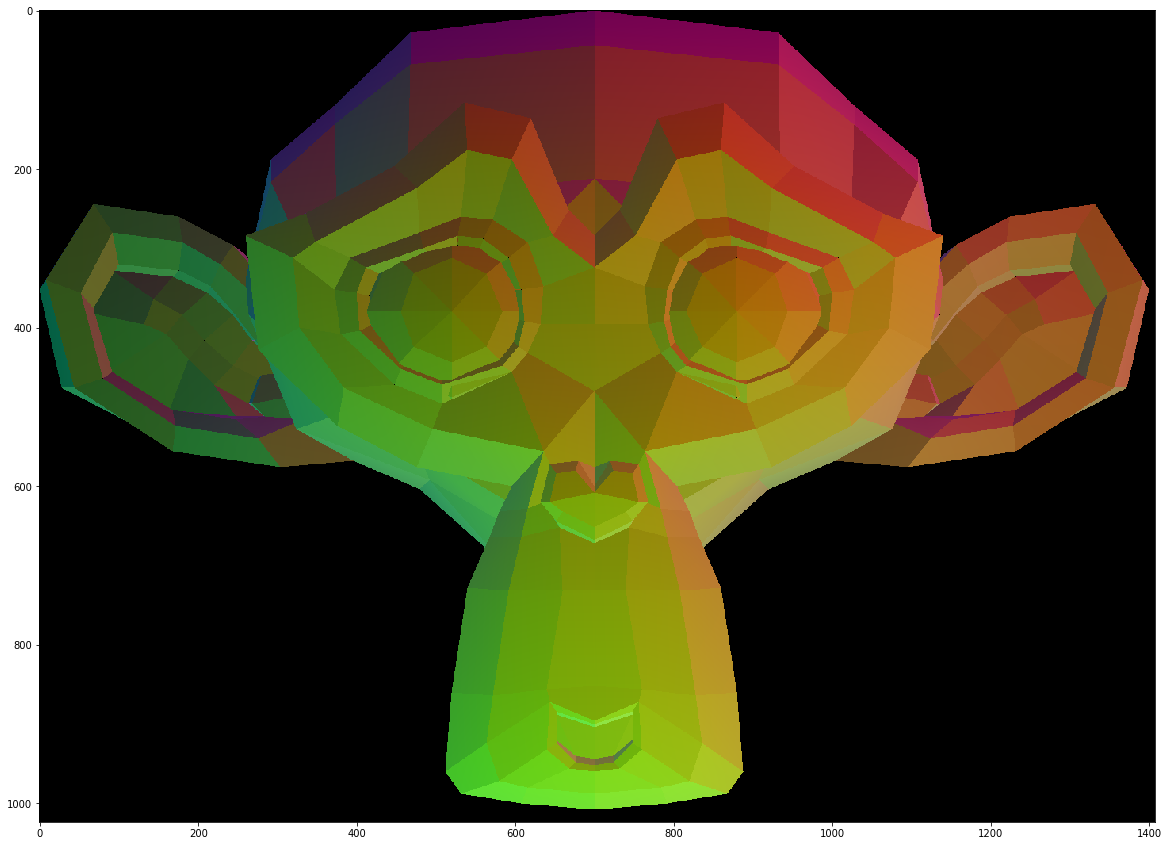

In [58]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(
    # tf.transpose(depth),
    tf.transpose(color, (1, 0, 2)),
    interpolation='nearest'
)
pass